In [1]:
import json
import cv2
import PIL.Image as Image
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm

In [2]:
label_list = [i for i in os.listdir() if os.path.isdir(i) and 'label' in i]
image_list = [i for i in os.listdir() if os.path.isdir(i) and 'image' in i]

In [3]:
label_root = 'label_one'
image_root = 'image_one'
json_list= [i for i in os.listdir(label_root) if '.json' in i]

In [4]:
json_file = []
for js_name in json_list:
    with open(os.path.join(label_root,js_name),'r', encoding='utf8') as f:
        contents = f.read()
        json_data = json.loads(contents)
    json_file.append(json_data['label_info'])

In [5]:
def abstract_polygon(json_list,filter=None,factor = 0):
    '''
    polygon을 추출하는 함수입니다.
    arg1: json_list -> 파싱된 json 파일들이 들어갑니다.
    arg2: filter -> bright로 더 밝게, red로 더 빨갛게 필터를 넣을 수 있습니다.
    arg3: factor -> 얼마나 필터를 강하게 넣을지 선택합니다. 0~1 의 값이 적당한 것 같습니다.

    출력은 polygon_list를 크기를 딱 맞게 필터링해서 반환하게 됩니다.
    '''
    polygon_list = []
    factor = factor + 1
    for i in tqdm(json_list) :
        pt = i['shapes'][0]['points']
        lft = int(min(pt)[0])
        rig = int(max(pt)[0])
        tp = int(max(pt,key=lambda x:x[1])[1])
        bot = int(min(pt,key=lambda x:x[1])[1])
        width = i['image']['width']
        height = i['image']['height']
        polygon = np.array(pt,dtype=np.int32)
        empty_array = np.zeros((height,width,3),np.uint8)
        polygon = cv2.fillPoly(empty_array,[polygon],(255,255,255))
        image = cv2.imread(os.path.join(image_root,i['image']['file_name']))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        if filter == 'bright':
            image = cv2.add(image,np.full(image.shape,(100*factor,100*factor,100*factor),dtype=np.uint8))
        if filter == 'red':
            image = cv2.add(image,np.full(image.shape,(100*factor,70/factor,70/factor),dtype=np.uint8))
        polygon2 = cv2.bitwise_and(image,polygon)
        polygon2 = polygon2[bot:tp,lft:rig,:].copy()
        polygon = polygon[bot:tp,lft:rig,:].copy()
        polygon_list.append([polygon2,polygon])
    return polygon_list


In [6]:
def image_conv(bg,fg):
    '''
    이미지 두개를 합성합니다.
    bg는 배경이 될 이미지를 의미합니다.
    fg는 abstract_polygon에서 반환된 값이 들어가면 됩니다.

    bg의 정 중앙에 fg가 맞게 합성된 이미지가 반환됩니다.
    '''
    bgw,bgh = bg.shape[:2]
    fgw,fgh = fg[0].shape[:2]
    bgw = int((bgw-fgw)/2)
    bgh = int((bgh-fgh)/2)
    roi = bg[bgw:bgw+fgw,bgh:bgh+fgh,:]
    mask = cv2.bitwise_not(fg[1])
    roi = cv2.bitwise_and(roi,mask)
    roi = cv2.add(roi,fg[0])
    bg[bgw:bgw+fgw,bgh:bgh+fgh,:] = roi
    return bg

In [7]:
polygon_list = abstract_polygon(json_file[:20])
#brighter = abstract_polygon(json_file,'bright')
#red = abstract_polygon(json_file,'red')

100%|██████████| 20/20 [00:00<00:00, 33.95it/s]


In [10]:
'''
아직 배경에 맞는 이미지가 충분히 확보되지 않아서 임시로 하나만 넣어놨습니다. 
다같이 추가로 확보할 필요가 있을 것 같습니다.
'''
image = cv2.imread('plate.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = cv2.resize(image,(1024,1024))

In [11]:
count = 0

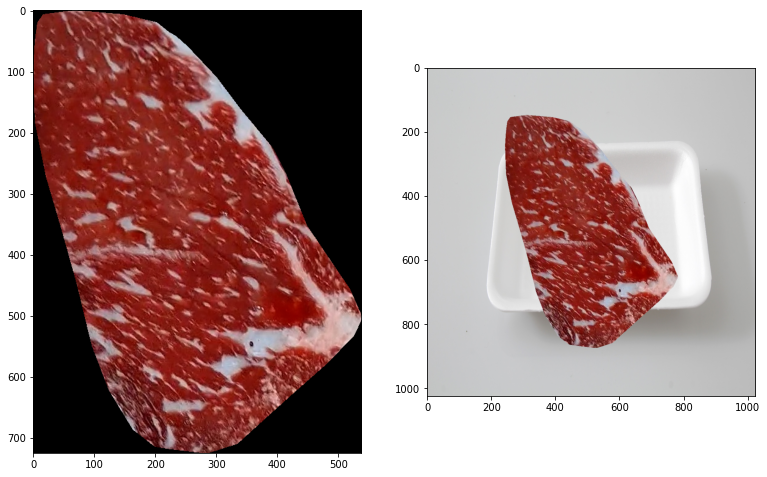

In [12]:
count = count +1
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(polygon_list[count][0])
plt.subplot(1,3,2)
img = image_conv(image,polygon_list[count])
plt.imshow(img)